In [13]:
## Standard libraries

import numpy as np 
import time
import imageio
import math
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

# Progress bar
from tqdm.notebook import tqdm

#machine learning specific
import torch.nn as nn

from sklearn.datasets import make_moons, make_circles
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset

from plots.plots import visualize_classification, plt_classifier
from models.training import Trainer, robTrainer, epsTrainer, epslinTrainer
from models.neural_odes import NeuralODE, robNeuralODE
from models.resnets import ResNet

import matplotlib.pyplot as plt






#if training = False, models will be loaded from file


torch.backends.cudnn.deterministic = True
torch.manual_seed(2)
torch.cuda.manual_seed(2)

In [14]:
#Plot variables

save_model = False #train new network or load saved one
pretrained = False
num_epochs = 50 #80 #number of optimization epochs for gradient decent

#model and training parameters
epsilons = [0]
# epsilons = [0 , 0.2, 0.5, 0.7]#, 0.01, 0.1, 0.5]#, 0.0001, 0.0002]#, 0.0001, 0.001, 0.01]
non_linearity = 'tanh' #'sigmoid' #'tanh'
architecture = 'inside' #outside #bottleneck

#data
data_noise = 0.05


#plots
fig_name = '1alingen'
plot_steps = 0 #0 means only one plot is generated. plot_steps >0 means each plot_steps epochs one plot is generated


#quite fixed
hidden_dim, data_dim = 2, 2 
T, num_steps = 5.0, 5 #20 before  #T is the end time, num_steps are the amount of discretization steps for the ODE solver
dt = T/num_steps
turnpike = False

bound = 0.
fp = False
cross_entropy = True

shuffle = False


if turnpike:
    weight_decay = 0 if bound>0. else dt*0.01
else: 
    weight_decay = dt*0.01          #0.01 for fp, 0.1 else







In [15]:
###DATA PREPARATION
X, y = make_circles(3000, noise=data_noise, factor=0.15, random_state=1, shuffle = shuffle)
# X, y = make_moons(3000, noise = noise, random_state = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.05 ) #random_state=2, shuffle = shuffle)

X_train = torch.Tensor(X_train) # transform to torch tensor for dataloader
y_train = torch.Tensor(y_train) #transform to torch tensor for dataloader

X_test = torch.Tensor(X_train) # transform to torch tensor for dataloader
y_test = torch.Tensor(y_train) #transform to torch tensor for dataloader

X_train = X_train.type(torch.float32)  #type of orginial pickle.load data
y_train = y_train.type(torch.int64) #dtype of original picle.load data

X_test = X_test.type(torch.float32)  #type of orginial pickle.load data
y_test = y_test.type(torch.int64) #dtype of original picle.load data


data_line = TensorDataset(X_train,y_train) # create your datset
test = TensorDataset(X_test, y_test)



g = torch.Generator()
g.manual_seed(1)

dataloader = DataLoader(data_line, batch_size=64, shuffle=shuffle, generator=g)
dataloader_viz = DataLoader(data_line, batch_size=128, shuffle=shuffle, generator = g)

/home/np1/staff/woehrer/FAUbox/Python/borjan dynamical.systems/plots/plots.py:389: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  predictions = m(pre_)


1alingen1_0_0 created


TypeError: 'int' object is not subscriptable

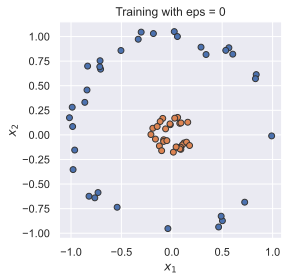

In [16]:
#MODEL INITIALIZITAION AND TRAINING

sort_num = 1

for eps in epsilons:

    # torch.manual_seed(2)

    eps_node = NeuralODE(device, data_dim, hidden_dim, adjoint = False, augment_dim=0, non_linearity=non_linearity, 
                                architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
    if pretrained:
        eps_node.load_state_dict(torch.load('rob_node.pth'))
    
        
        
    # for name, param in eps_node.named_parameters():
    #     i = 0
    #     if param.requires_grad and i<2:
    #         print(name, param.data)
    #         i += 1

    optimizer_node = torch.optim.Adam(eps_node.parameters(), lr=1e-3, weight_decay = weight_decay) #weight decay parameter modifies norm
    trainer_eps_node = epslinTrainer(eps_node, optimizer_node, device, cross_entropy = cross_entropy, 
                            turnpike=turnpike, bound=bound, fixed_projector=fp, verbose = False, eps =  eps)
    
    if plot_steps == 0:
        plot_steps = num_epochs

    for h, i in enumerate(range(1,num_epochs+1, plot_steps)):
    
        trainer_eps_node.train(dataloader, plot_steps)

        fig_name_plot = fig_name + str(sort_num) + '_' + str(eps) + '_' + str(h)
        footnote = 'plot_count = {}, eps = {}, epochs = {}, data_noise = {}'.format(i, eps, num_epochs, data_noise)
        plt_classifier(eps_node,  data_line, test, num_steps=10, trainer = trainer_eps_node, footnote = footnote, save_fig = '{}'.format(fig_name_plot) +'.png') 
        print('{} created'.format(fig_name_plot))

        for x_batch, y_batch in dataloader:
            grad = 0
            visualize_classification(eps_node, x_batch, y_batch, grad, eps = 0)
        sort_num += 1

tensor([[[0.9776],
         [0.4367],
         [0.0216]],

        [[0.8505],
         [0.3132],
         [0.6487]],

        [[0.1859],
         [0.8875],
         [0.3024]]])


tensor([[[0.9776, 0.4367, 0.0216],
         [0.8505, 0.3132, 0.6487],
         [0.1859, 0.8875, 0.3024]]])